In [1]:
import numpy as np
import matplotlib.pylab as plt

import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.dispersion import DispersionFitter

Output()

num_Al2O3 122230
num_SiO2 44


[18:17:35] WARNING:        warning: did not find fit with RMS error under tolerance_rms of 2.00e-02      ]8;id=989417;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\plugins\dispersion\fit.py\fit.py]8;;\:]8;id=361881;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\plugins\dispersion\fit.py#366\366]8;;\

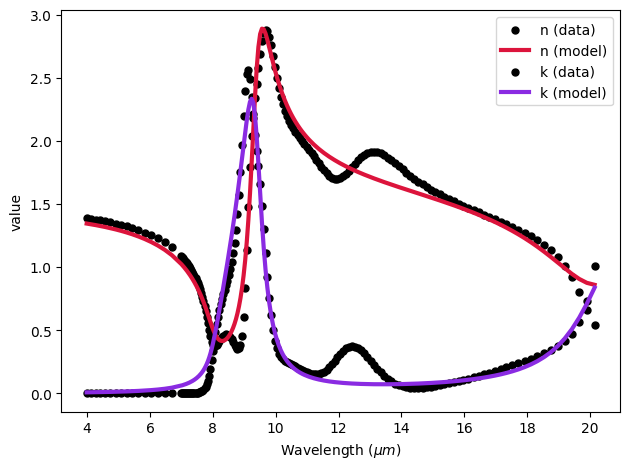

Output()

[18:18:28] WARNING:        warning: did not find fit with RMS error under tolerance_rms of 2.00e-02      ]8;id=873516;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\plugins\dispersion\fit.py\fit.py]8;;\:]8;id=633882;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\plugins\dispersion\fit.py#366\366]8;;\

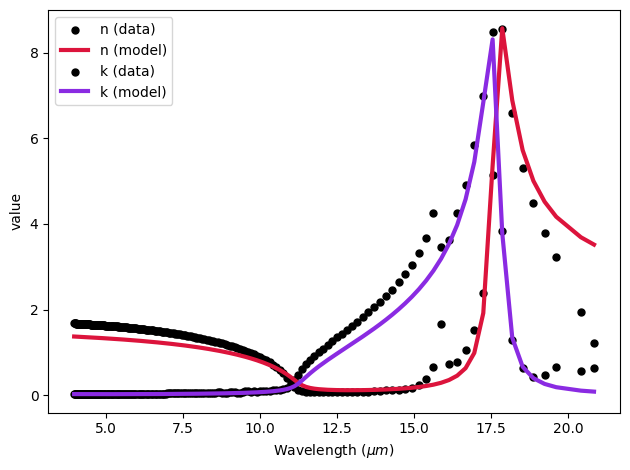

freq_start: 14989622900000.0
freq_end: 74948114500000.0
lda0: 6.666666666666667
sim_size: (20, 20, 180)


In [2]:
# Define Paramters
# radius and location of the sphere
radius_Al2O3 = 0.25
radius_SiO2 = 4 # exp is 6um
box_size_xy = 20
box_size_z = 100

vol_Al2O3 = 4/3 * np.pi * np.power(radius_Al2O3,3)
vol_SiO2 = 4/3 * np.pi * np.power(radius_SiO2,3)
vol_box = box_size_xy * box_size_xy * box_size_z
num_Al2O3 = int(np.floor(0.2 * vol_box / vol_Al2O3))   # 20% of volumn is Al2O3
num_SiO2 = int(np.floor(0.3 * vol_box / vol_SiO2))   # 30% of volumn is SiO2
print('num_Al2O3',num_Al2O3)
print('num_SiO2',num_SiO2)

center = [0, 0, 0]

# permittivity of the Al2O3 sphere 
mat_SiO2 = "data/mat_SiO2.csv"
mat_Al2O3 = "data/mat_Al2O3.csv"

# note that additional keyword arguments to load_nk_file get passed to np.loadtxt
fitter = DispersionFitter.from_file(mat_SiO2, skiprows=1, delimiter=",")
medium_SiO2, rms_error = fitter.fit(num_poles=3, tolerance_rms=2e-2, num_tries=100)
fitter.plot(medium_SiO2)
plt.show()

fitter = DispersionFitter.from_file(mat_Al2O3, skiprows=1, delimiter=",")
medium_Al2O3, rms_error = fitter.fit(num_poles=3, tolerance_rms=2e-2, num_tries=100)
fitter.plot(medium_Al2O3)
plt.show()

# free space central wavelength
wl_start = 4  # wavelength
wl_end = 20  # wavelength
freq_start = td.C_0 / wl_end
freq_end = td.C_0 / wl_start
print('freq_start:',freq_start)
print('freq_end:',freq_end)

freqs = np.linspace(freq_start, freq_end, 100)  # freqeucny range of the simulation
freq0 = (freq_start + freq_end)/2  # central frequency
freqw = freq_end - freq_start  # width of the frequency range

lda0 = td.C_0 / freq0
print('lda0:',lda0)

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_PML = 2 * wl_end
buffer_source = 1 * wl_end

# resolution control
min_steps_per_wvl = 20

# set the domain size in x, y, and z
domain_size_xy = box_size_xy 
domain_size_z = buffer_PML + box_size_z + buffer_PML

# construct simulation size array
sim_size = (domain_size_xy, domain_size_xy, domain_size_z)
print('sim_size:',sim_size)

In [3]:
# Create random structures
geometry = []
for i in range(num_SiO2):
    position_xy = (box_size_xy - 2*radius_SiO2) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_SiO2) * (np.random.rand(1) - 0.5) 
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Structure(geometry=td.Sphere(center=position, radius=radius_SiO2), medium=medium_SiO2)
    geometry.append(sphere)
    
for i in range(num_Al2O3):
    position_xy = (box_size_xy - 2*radius_Al2O3) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_Al2O3) * (np.random.rand(1) - 0.5)
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Structure(geometry=td.Sphere(center=position, radius=radius_Al2O3), medium=medium_Al2O3)
    geometry.append(sphere)    
    
geometry = tuple(geometry)
print('Geometry Finish')

Geometry Finish


In [4]:
# add a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, box_size_z/2 + buffer_source),
    direction="-",
    pol_angle=0,
)

# add a flux monitor to detect transmission
monitor_t = td.FluxMonitor(
    center=[0, 0, -box_size_z/2 - (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="T"
)

# add a flux monitor to detect reflection
monitor_r = td.FluxMonitor(
    center=[0, 0, box_size_z/2 + (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# add a field monitor to see the field profile at the absorption peak frequency
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, box_size_z], freqs=[freq0], name="field"
)

print('Source and Monitor setup Finish')

Source and Monitor setup Finish


In [5]:
run_time = 2e-11  # simulation run time

# set up simulation
sim = td.Simulation(
    size=sim_size,
#     grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0), # Non uniform grip
    grid_spec=td.GridSpec.uniform(dl =lda0/20),
    structures=geometry,
    sources=[plane_wave],
    monitors=[monitor_t, monitor_r, monitor_field],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ), 
#     boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # PML boundary
)  # symmetry can be used to greatly reduce the computational cost

print('Simulation setup Finish')

Simulation setup Finish


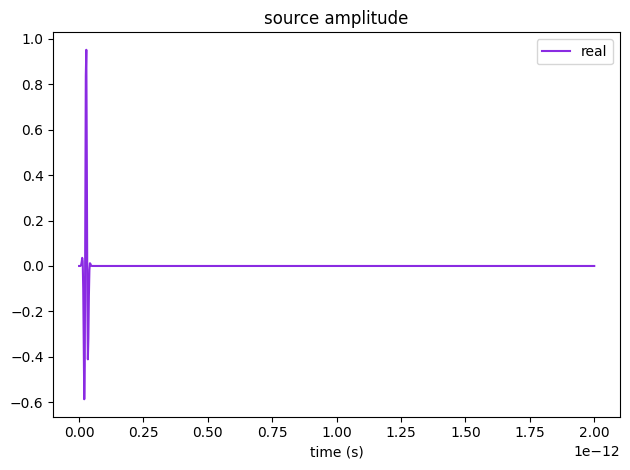

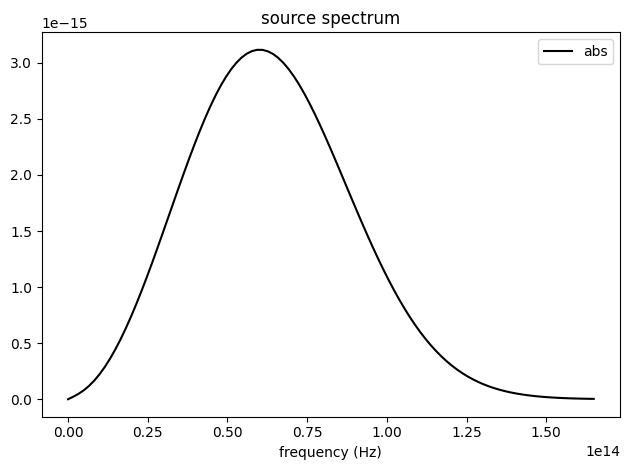

In [6]:
# Visualize source
plane_wave.source_time.plot(np.linspace(0, run_time/10, 1001))
plt.show()

plane_wave.source_time.plot_spectrum(
    times=np.linspace(0, run_time/10, 2000), val="abs"
)
plt.show()

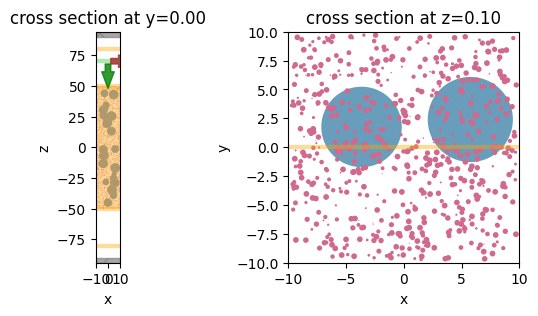

Visualize Source Finish


In [7]:
cfig, ax = plt.subplots(1, 2, figsize=(7, 3))
sim.plot(y=0, ax=ax[0])
sim.plot(z=0.1, freq=freq0, ax=ax[1])
plt.show()

print('Visualize Source Finish')

In [8]:
task_id = web.upload(sim, task_name="Simulation")
# print("Max flex unit cost: ", web.estimate_cost(task_id))

[18:19:58] Created task 'Simulation' with task_id 'fdve-9bde8408-6d62-4fb7-a8e8-b0f36a885ffdv1'.      ]8;id=27661;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=312607;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=901872;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=524784;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=721515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bde8408-6d62-4fb7-a8e8-b0f36a885ffdv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=681822;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bde8408-6d62-4fb7-a8e8-b0f36a885ffdv1\taskId]8;;\]8;id=721515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bde8408-6d62-4fb7-a8e8-b0f36a885ffdv1\=]8;;\]8;id=331834;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bde8408-6d62-4fb7-a8e8-b0f36a885ffdv1\fdve]8;;\]8;id=721515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bde8408-6d62-4fb7-a8e8-b0f36a885ffdv1\-9bde8408-6d62-4fb7-a8e8-b0f36a885ff]8;;\              
           ]8;id=721515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bde8408-6d62-4fb7-a8e8-b0f36a885ffdv1\dv1']8;;\.                                                                                                   

Output()

In [9]:
web.start(task_id)
web.monitor(task_id, verbose=True)

import time
time.sleep(4)
print("Billed flex unit cost: ", web.real_cost(task_id))

sim_data = web.load(task_id, path="data/cooling.hdf5")

# Show the output of the log file
print(sim_data.log)

[18:21:15] status = queued                                                                            ]8;id=101389;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=996311;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[18:24:04] status = preprocess                                                                        ]8;id=433291;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=201800;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[18:28:08] Maximum FlexCredit cost: 0.067. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=598247;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=499253;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=699467;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=885688;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=648861;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=480974;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[18:28:41] early shutoff detected, exiting.                                                           ]8;id=566094;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=802808;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=869532;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=919864;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[18:29:49] status = success                                                                           ]8;id=429026;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=376000;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#390\390]8;;\

[18:29:54] WARNING: Billed FlexCredit for task 'fdve-9bde8408-6d62-4fb7-a8e8-b0f36a885ffdv1' is not   ]8;id=623422;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=358871;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#726\726]8;;\
           available. If the task has been successfully run, it should be available shortly.                       

Billed flex unit cost:  0.0


Output()

[18:30:19] loading SimulationData from data/cooling.hdf5                                              ]8;id=73121;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=694216;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#568\568]8;;\

Simulation domain Nx, Ny, Nz: [60, 60, 564]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 2.0376e+06.
Using subpixel averaging: True
Number of time steps: 3.1472e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 6.3552e-16


Compute source modes time (s):     231.3426
Compute monitor modes time (s):    4.0197
Rest of setup time (s):            17.1975

Running solver for 31472 time steps...
- Time step     42 / time 2.67e-14s (  0 % done), field decay: 1.00e+00
- Time step   1258 / time 7.99e-13s (  4 % done), field decay: 1.68e-02
- Time step   2517 / time 1.60e-12s (  8 % done), field decay: 5.97e-04
- Time step   3776 / time 2.40e-12s ( 12 % done), field decay: 1.35e-04
- Time step   5035 / time 3.20e-12s ( 16 % done), field decay: 5.56e-05
- Time step   6294 / time 4.00e-12s ( 20 % done), field decay: 3.30e-05
- Time step   7553 / time 4.80e-12s ( 24 % done), field decay: 1.82e-05
- Time step   8812 / time 5.60e-12s ( 28 % done), field decay: 1.47e-05
- Tim

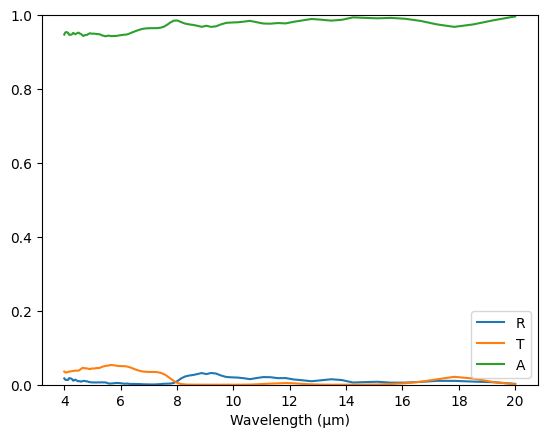

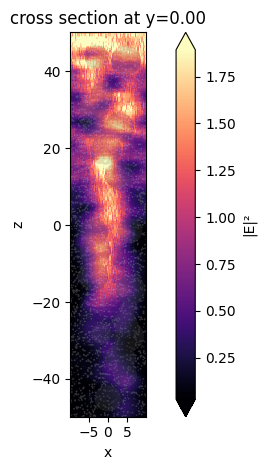

In [10]:
# Result Visualization
R = sim_data["R"].flux
T = -sim_data["T"].flux
A = 1 - R - T
plt.plot(td.C_0 /freqs, R, td.C_0 /freqs, T, td.C_0 /freqs, A)
np.savetxt('data/Abs_4-20um.txt', (np.transpose((td.C_0 /freqs, A))))

plt.xlabel("Wavelength (μm)")
plt.ylim(0, 1)
plt.legend(("R", "T", "A"))
plt.show()

sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()